In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import linalg, matrix, optimize
from scipy.integrate import odeint
import sympy as sy
from sklearn.preprocessing import PolynomialFeatures
import tensorflow as tf

def lowestEigenspaces(A,num=1):
    u, s, vt = scipy.linalg.svd(A)
    n = len(s)
    # reverse the n first columns of u
    u[:,:n] = u[:, n-1::-1]
    # reverse s
    s = s[::-1]
    # reverse the n first rows of vt
    vt[:n, :] = vt[n-1::-1, :]
    #print(vt)
    #print(vt[0:num])
    #print(vt[0:num,:])
    null_space = vt[0:num]
    return scipy.transpose(null_space)

def null(A,eps=1e-9):
    u, s, vh = scipy.linalg.svd(A)
    padding = max(0,np.shape(A)[1]-np.shape(s)[0])
    null_mask = np.concatenate(((s <= eps), np.ones((padding,),dtype=bool)),axis=0)
    null_space = scipy.compress(null_mask, vh, axis=0)
    return scipy.transpose(null_space)

class PlaneCurvePoints():
    def __init__(self,circleTrue=True,r=1,a=3,b=2):
        self.circleTrue=circleTrue
        self.r=r
        self.a=a
        self.b=b
    def myCircle(self,x,y):
        return x**2+y**2-self.r**2
    def myCircle2(self,x):
        return [x[0]**2+x[1]**2-self.r**2,0]
    def myEllipticCurve(self,x,y):
        return y**2-x**3-self.a*x-self.b
    def myEllipticCurve2(self,x):
        return [x[1]**2-x[0]**3-self.a*x[0]-self.b,0]
    def selectDataPointsPlaneCurve2(equation):
        x = np.linspace(-3, 3, 10)
        y = np.linspace(-3, 3, 10)
        z = np.zeros((10*10,2))
        i=0
        for x0 in x:
            for y0 in y:
                z0 = scipy.optimize.root(equation,[x0,y0]).x
                z[i]=z0
                i=i+1
        return z
    def selectDataPointsPlaneCurve(equation):
        x = np.linspace(-3, 3, 100)
        y = np.linspace(-3, 3, 100)
        x,y = np.meshgrid(x, y)
        z = equation(x,y)
        CS = plt.contour(x,y,z,[0.0])
        dat0= CS.allsegs[0][0]
        return dat0
    def selectMyDataPoints(self,noise=False):
        if (self.circleTrue):
            toReturn=PlaneCurvePoints.selectDataPointsPlaneCurve(self.myCircle)
        else:
            toReturn=PlaneCurvePoints.selectDataPointsPlaneCurve(self.myEllipticCurve)
        if (noise):
            length=len(toReturn)
            return toReturn + .05*np.random.randn(length,2)
        return toReturn

def definingEquations(dataPoints,degree=3,num=1):
    poly= PolynomialFeatures(degree)
    monomials=poly.fit_transform(dataPoints)
    defining_equation=lowestEigenspaces(monomials,num)
    #print(defining_equation)
    return defining_equation

def doTestCases(numIOMs):
    myExample=PlaneCurvePoints(circleTrue=False,a=2,b=1)
    dataPoints=myExample.selectMyDataPoints()
    IOM=definingEquations(dataPoints,degree=3,num=numIOMs)[1:]
    plt.scatter(dataPoints[:,0],dataPoints[:,1])
    roundedIOM=IOM.round(decimals=4)
    plt.title("Elliptic Curve y^2 = x^3 + {0}*x+{1} and found conserved quantity(ies) {2}".format(myExample.a,myExample.b,IOM))
    plt.show()
    plt.close()
    myExample=PlaneCurvePoints(circleTrue=True,r=1.4)
    dataPoints=myExample.selectMyDataPoints()
    IOM=definingEquations(dataPoints,degree=2,num=numIOMs)[1:]
    roundedIOM=IOM.round(decimals=4)
    plt.scatter(dataPoints[:,0],dataPoints[:,1])
    plt.title("Circle x^2 + y^2 = {0} and found conserved quantity(ies) {1}".format(myExample.r,IOM))
    plt.show()
    plt.close()
    
class HamiltonianOptions():
    def harmonic_oscillator_deriv(x,t,myParams=None):
        try:
            omega=myParams[0]
            mass=myParams[1]
        except:
            omega = 3.0
            mass = .5
            # H = p^2 / (2*(m=.5)) + 1/2 (m=.5) (omega=3.0)^2 x^2
        nx0 = x[0]
        npx0 = x[1]
        res = np.array([npx0,-mass*omega**2*nx0])
        return res
    def vanDerPol_oscillator_deriv(x,t,myParams=None):
        try:
            mu = myParams[0]
        except:
            mu = 3.0
            # H = px py + x y - 3.0 (1-x^2) y py
        nx0=x[0]
        ny0=x[1]
        npx0=x[2]
        npy0=x[3]
        res=np.array([npy0,npx0-mu*(1-nx0**2)*ny0,-ny0-2*mu*nx0*ny0*npy0,-nx0+mu*npy0-mu*nx0**2*npy0])
        return res
    def volterra_deriv(x,t,myParams=None):
        try:
            epsilon_1 = myParams[0]
            epsilon_2 = myParams[1]
            a_12 = myParams[2]
            a_21 = myParams[3]
        except:
            epsilon_1 = -.2
            epsilon_2 = 0
            a_12 = 4.0
            a_21 = -a_12
            # H = -.2 q1 + 0 q2 - e^(p1 + 1/2 4 q2) - e^(p2 + 1/2 -4 q1)
        q1, q2, p1, p2 = sy.symbols('q1 q2 p1 p2', real=True)
        H = epsilon_1*q1 + epsilon_2*q2 - sy.exp(p1+.5*a_12*q2) - sy.exp(p2+.5*a_21*q1)
        dotq1=-sy.diff(H,p1)
        dotq2=-sy.diff(H,p2)
        dotp1=sy.diff(H,q1)
        dotp2=sy.diff(H,q2)
        nq1 = x[0]
        nq2 = x[1]
        npq1 = x[2]
        npq2 = x[3]
        ndotq1=dotq1.subs([(q1,nq1),(q2,nq2),(p1,npq1),(p2,npq2)]).evalf()
        ndotq2=dotq2.subs([(q1,nq1),(q2,nq2),(p1,npq1),(p2,npq2)]).evalf()
        ndotp1=dotp1.subs([(q1,nq1),(q2,nq2),(p1,npq1),(p2,npq2)]).evalf()
        ndotp2=dotp2.subs([(q1,nq1),(q2,nq2),(p1,npq1),(p2,npq2)]).evalf()
        ndotq1=np.float64(ndotq1)
        ndotq2=np.float64(ndotq2)
        ndotp1=np.float64(ndotp1)
        ndotp2=np.float64(ndotp2)
        res = np.array([ndotq1,ndotq2,ndotp1,ndotp2])
        return res
    def generic1DOFPoly_deriv(x,t,myParams,degree):
        q1, p1 = sy.symbols('q1 p1', real=True)
        currentIndex=0
        H=0
        for currentDegree in range(degree):
            for j in range(currentDegree+2):
                print(H)
                H+=myParams[currentIndex]*q1**(currentDegree+1-j)*p1**(j)
                currentIndex=currentIndex+1
        print(H)
        dotq1=-sy.diff(H,p1)
        dotp1=sy.diff(H,q1)
        nq1 = x[0]
        npq1 = x[1]
        ndotq1=dotq1.subs([(q1,nq1),(p1,npq1)]).evalf()
        ndotp1=dotp1.subs([(q1,nq1),(p1,npq1)]).evalf()
        ndotq1=np.float64(ndotq1)
        ndotp1=np.float64(ndotp1)
        res = np.array([ndotq1,ndotp1])
        return res
    def __init__(self,myType,myParams):
        if (myType==0):
            self.equation=lambda x,t: HamiltonianOptions.harmonic_oscillator_deriv(x,t,myParams)
        elif (myType==1):
            self.equation=lambda x,t: HamiltonianOptions.vanDerPol_oscillator_deriv(x,t,myParams)
        else:
            self.equation=lambda x,t: HamiltonianOptions.volterra_deriv(x,t,myParams)
    def simulatedDynamics(self,t0,t1,numts,x0):
        ts = np.linspace(t0,t1,numts)
        xs = odeint(self.equation,x0,ts)
        return xs

def trySimulated():
    basicHO=HamiltonianOptions(0,None)
    ts = np.linspace(0,50.0,500)
    x0 = [4.0,0.0]
    xs = basicHO.simulatedDynamics(0,50.0,500,x0)
    plt.plot(ts,xs[:,0])
    plt.show()
    basicVDP=HamiltonianOptions(1,None)
    ts = np.linspace(0,50.0,500)
    x0 = [4.0,0.0,0.0,0.0]
    xs = basicVDP.simulatedDynamics(0,50.0,500,x0)
    plt.plot(ts,xs[:,0])
    plt.show()
    basicVolterra=HamiltonianOptions(2,None)
    ts = np.linspace(0,50.0,500)
    x0 = [4.0,0.0,0.0,0.0]
    xs = basicVolterra.simulatedDynamics(0,50.0,500,x0)
    plt.plot(ts,xs[:,0])
    plt.show()
    
class TrajectoryFitter():
    # input format of trajectoryData is (sampleNumber,time,whichDOF)
    def __init__(self,trajectoryData,sampleNumber=1,degree=3,numPerSample=1):
        # if there are multiple trajectories of same system, the initial conditions means they have different constants in defining equations
        # rather than try to put that info together, just concatenate the potential H_i from each
        # numperSample controls how many conserved quantities taken from each trajectory
        # they will be redundant but that's okay, just gathering a list of conserved quantites in this step
        self.sampleNumber=sampleNumber
        self.degree=degree
        self.numPerSample=numPerSample
        self.trajectoryData=trajectoryData
        self.trajectoryDataShape=trajectoryData.shape
        for i in range(sampleNumber):
            if (i==0):
                self.myIOM = definingEquations(trajectoryData[i],degree,numPerSample)[1:]
            else:
                self.myIOM = np.hstack(self.myIOM,definingEquations(trajectoryData[i],degree,numPerSample)[1:])
        # each column of self.myIOM is a conserved quantity the rows indicate which monomial is a coefficient of
        self.conservedShape = self.myIOM.shape
    # only handles systems with 1DOF so just a single position and momentum pair.
    def lossFunction(self,coeffsEachH):
        # these are the coefficients we wish to learn, the true hamiltonian is some polynomial combination of conserved quantities
        # for starters suppose we know it's a linear combination
        # the conserved quantities are stuck so now only doing gradient descent over these coefficients
        trialHamiltonian = np.matMul(self.myIOM,coeffsEachH)
        # when there is redundancy like having two columns for the same H_i, there is a flat direction from moving coefficient
        # back and forth, but that is a gauge symmetry
        loss=0
        for i in range(self.sampleNumber):
            for j in range(self.trajectoryDataShape[1]-1):
                actualDeriv=self.trajectoryData[i,j+1,:]-self.trajectoryData[i,j,:]
                predictedDeriv=HamiltonianOptions.generic1DOFPoly_deriv(self.trajectoryData[i,j,:],j,trialHamiltonian,self.degree)
                diff=predictedDeriv-actualDeriv                    
                loss+=np.sum(diff**2)
        return loss+self.l1Regularizer*np.sum(np.abs(trialHamiltonian))
    def doFit(self,l1Regularizer=100):
        # put in the loss function and descent
        self.l1Regularizer=l1Regularizer
        return scipy.optimize.minimize(self.lossFunction,x0=np.ones(self.conservedShape[1]),method='Nelder-Mead')

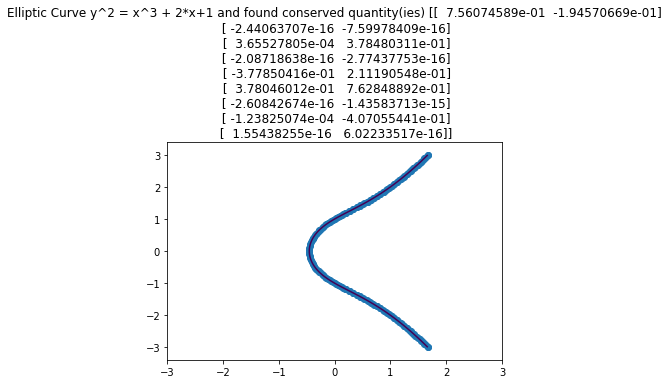

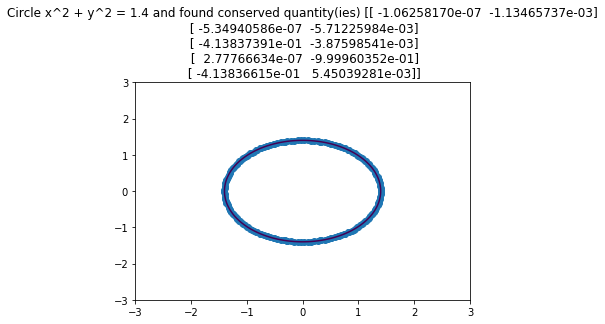

In [27]:
doTestCases(2)

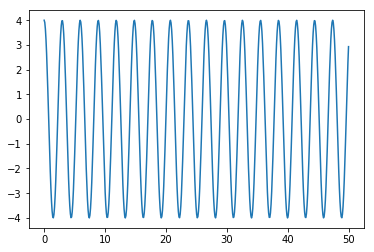

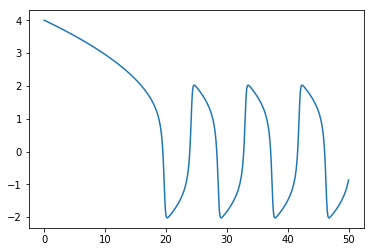

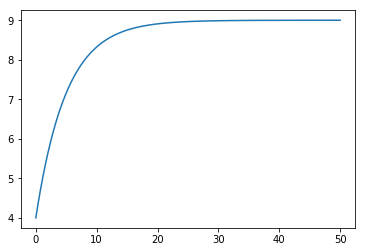

In [75]:
trySimulated()

In [13]:
HamiltonianOptions.generic1DOFPoly_deriv([0,0],0,[1,2,3,4,5],2)

0
q1
2*p1 + q1
2*p1 + 3*q1**2 + q1
4*p1*q1 + 2*p1 + 3*q1**2 + q1
5*p1**2 + 4*p1*q1 + 2*p1 + 3*q1**2 + q1


array([-2.,  1.])